<img src="1.png" width="450">
<img src="2.png" width="450">
<img src="3.png" width="450">
<img src="4.png" width="450">
<img src="5.png" width="450">
<img src="6.png" width="450">
<img src="7.png" width="450">
<img src="8.png" width="450">
<img src="9.png" width="450">
<img src="10.png" width="450">

---
---
---

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn import metrics

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
train = pd.read_csv('flight_delays_train.csv')
test = pd.read_csv('flight_delays_test.csv')

* DepTime, время отправления
* UniqueCarrier, код перевозчика
* Origin, место вылета
* Dest, место назначения
* Distance, расстояние между аэропортами вылета и прилета

In [3]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [4]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


Итак, надо по времени вылета самолета, коду авиакомпании-перевозчика, месту вылета и прилета и расстоянию между аэропортами вылета и прилета предсказать задержку вылета более 15 минут. 

В качестве простейшего бенчмарка возьмем логистическую регрессию и два наиболее простых признака: DepTime и Distance:

In [5]:
X_train, y_train = train[['Distance', 'DepTime']].values, train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values

X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, 
                                                                y_train, 
                                                                test_size=0.3, 
                                                                random_state=17)

In [6]:
logit = LogisticRegression(random_state=17)

logit.fit(X_train_part, y_train_part)
logit_valid_pred = logit.predict_proba(X_valid)[:, 1]

roc_auc_score(y_valid, logit_valid_pred)

0.6795697123357751

In [7]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]

pd.Series(logit_test_pred, name='dep_delayed_15min').to_csv('logit_2feat.csv', 
                                                               index_label='id', 
                                                               header=True)

In [8]:
y = train['dep_delayed_15min']
X = train.drop(['dep_delayed_15min'], axis=1)

y = y.replace(to_replace=['N', 'Y'], value=[0, 1])

In [9]:
X.sample()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
89504,c-11,c-15,c-3,817,AA,MIA,LAX,2342


In [10]:
y.sample()

90215    0
Name: dep_delayed_15min, dtype: int64

In [11]:
list(X.dtypes)

[dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64'),
 dtype('O'),
 dtype('O'),
 dtype('O'),
 dtype('int64')]

In [12]:
categorical = np.array( X.select_dtypes(include=['object']).columns.tolist() )
categorical

array(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin',
       'Dest'], dtype='<U13')

In [13]:
numerical = np.setdiff1d( np.array(X.columns.tolist()), categorical )
numerical

array(['DepTime', 'Distance'], dtype='<U13')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [15]:
X_train.shape

(70000, 8)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_recall_curve, auc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [17]:
def draw_roc_curve(fpr, tpr):
    fig, ax = plt.subplots(1,1, figsize=(8,8))

    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("ROC curve")

    plt.plot(fpr, tpr, color='blue')
    plt.plot((0,1), (0,1), color='red')

In [18]:
column_ohe_transformer = ColumnTransformer([
                                            ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
                                            ('scaling', StandardScaler(), numerical)
                                        ])

X_train_ohe = column_ohe_transformer.fit_transform(X_train)
X_test_ohe = column_ohe_transformer.transform(X_test)

X_train_ohe.shape

(70000, 648)

In [19]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train[numerical], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [20]:
preds_proba = xgb_model.predict_proba(X_test[numerical])
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [21]:
roc_auc_score(y_test, preds_proba[:, 1])

0.7092680502055139

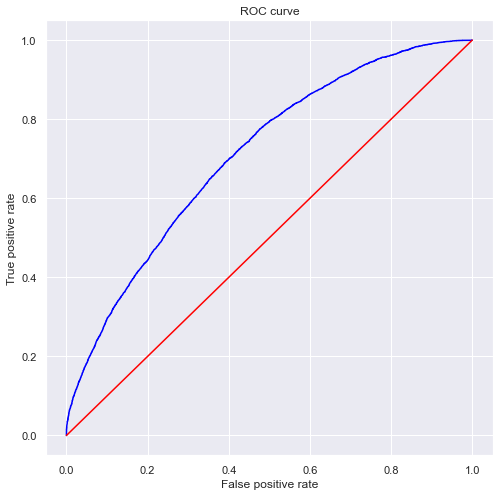

In [22]:
draw_roc_curve(fpr, tpr)

Вообще, я уже побил необходимый скор. Но можем еще немного поразвлекаться.

In [23]:
cb_model = CatBoostClassifier()
cb_model.fit(X_train[numerical], y_train)

Learning rate set to 0.063211
0:	learn: 0.6593682	total: 78.4ms	remaining: 1m 18s
1:	learn: 0.6304854	total: 97.8ms	remaining: 48.8s
2:	learn: 0.6061014	total: 115ms	remaining: 38.2s
3:	learn: 0.5853297	total: 131ms	remaining: 32.5s
4:	learn: 0.5679407	total: 144ms	remaining: 28.7s
5:	learn: 0.5524039	total: 160ms	remaining: 26.5s
6:	learn: 0.5387489	total: 176ms	remaining: 25s
7:	learn: 0.5270656	total: 192ms	remaining: 23.8s
8:	learn: 0.5175360	total: 222ms	remaining: 24.5s
9:	learn: 0.5086229	total: 239ms	remaining: 23.6s
10:	learn: 0.5004026	total: 257ms	remaining: 23.1s
11:	learn: 0.4937720	total: 273ms	remaining: 22.5s
12:	learn: 0.4884420	total: 286ms	remaining: 21.7s
13:	learn: 0.4841613	total: 299ms	remaining: 21.1s
14:	learn: 0.4800370	total: 314ms	remaining: 20.6s
15:	learn: 0.4765688	total: 333ms	remaining: 20.5s
16:	learn: 0.4732573	total: 351ms	remaining: 20.3s
17:	learn: 0.4703953	total: 369ms	remaining: 20.1s
18:	learn: 0.4680218	total: 382ms	remaining: 19.7s
19:	learn:

170:	learn: 0.4437184	total: 3.64s	remaining: 17.7s
171:	learn: 0.4437027	total: 3.66s	remaining: 17.6s
172:	learn: 0.4436824	total: 3.67s	remaining: 17.6s
173:	learn: 0.4436651	total: 3.69s	remaining: 17.5s
174:	learn: 0.4436337	total: 3.7s	remaining: 17.5s
175:	learn: 0.4436075	total: 3.72s	remaining: 17.4s
176:	learn: 0.4435906	total: 3.74s	remaining: 17.4s
177:	learn: 0.4435659	total: 3.76s	remaining: 17.4s
178:	learn: 0.4435376	total: 3.79s	remaining: 17.4s
179:	learn: 0.4435299	total: 3.81s	remaining: 17.4s
180:	learn: 0.4434951	total: 3.83s	remaining: 17.3s
181:	learn: 0.4434679	total: 3.85s	remaining: 17.3s
182:	learn: 0.4434555	total: 3.87s	remaining: 17.3s
183:	learn: 0.4434335	total: 3.88s	remaining: 17.2s
184:	learn: 0.4434053	total: 3.9s	remaining: 17.2s
185:	learn: 0.4433869	total: 3.92s	remaining: 17.1s
186:	learn: 0.4433659	total: 3.94s	remaining: 17.1s
187:	learn: 0.4433418	total: 3.95s	remaining: 17.1s
188:	learn: 0.4433160	total: 3.97s	remaining: 17.1s
189:	learn: 0.

330:	learn: 0.4394949	total: 7.29s	remaining: 14.7s
331:	learn: 0.4394629	total: 7.31s	remaining: 14.7s
332:	learn: 0.4394303	total: 7.33s	remaining: 14.7s
333:	learn: 0.4394060	total: 7.34s	remaining: 14.6s
334:	learn: 0.4393877	total: 7.36s	remaining: 14.6s
335:	learn: 0.4393626	total: 7.37s	remaining: 14.6s
336:	learn: 0.4393437	total: 7.39s	remaining: 14.5s
337:	learn: 0.4393243	total: 7.41s	remaining: 14.5s
338:	learn: 0.4393077	total: 7.42s	remaining: 14.5s
339:	learn: 0.4392856	total: 7.44s	remaining: 14.5s
340:	learn: 0.4392550	total: 7.46s	remaining: 14.4s
341:	learn: 0.4392350	total: 7.49s	remaining: 14.4s
342:	learn: 0.4392206	total: 7.51s	remaining: 14.4s
343:	learn: 0.4391994	total: 7.53s	remaining: 14.4s
344:	learn: 0.4391722	total: 7.55s	remaining: 14.3s
345:	learn: 0.4391433	total: 7.58s	remaining: 14.3s
346:	learn: 0.4391199	total: 7.6s	remaining: 14.3s
347:	learn: 0.4390972	total: 7.62s	remaining: 14.3s
348:	learn: 0.4390713	total: 7.64s	remaining: 14.2s
349:	learn: 0

491:	learn: 0.4360472	total: 10.5s	remaining: 10.8s
492:	learn: 0.4360297	total: 10.5s	remaining: 10.8s
493:	learn: 0.4359975	total: 10.5s	remaining: 10.8s
494:	learn: 0.4359737	total: 10.6s	remaining: 10.8s
495:	learn: 0.4359543	total: 10.6s	remaining: 10.7s
496:	learn: 0.4359170	total: 10.6s	remaining: 10.7s
497:	learn: 0.4359022	total: 10.6s	remaining: 10.7s
498:	learn: 0.4358791	total: 10.6s	remaining: 10.7s
499:	learn: 0.4358609	total: 10.7s	remaining: 10.7s
500:	learn: 0.4358342	total: 10.7s	remaining: 10.6s
501:	learn: 0.4358172	total: 10.7s	remaining: 10.6s
502:	learn: 0.4357966	total: 10.7s	remaining: 10.6s
503:	learn: 0.4357610	total: 10.7s	remaining: 10.6s
504:	learn: 0.4357284	total: 10.8s	remaining: 10.5s
505:	learn: 0.4357137	total: 10.8s	remaining: 10.5s
506:	learn: 0.4356778	total: 10.8s	remaining: 10.5s
507:	learn: 0.4356529	total: 10.8s	remaining: 10.5s
508:	learn: 0.4356357	total: 10.8s	remaining: 10.4s
509:	learn: 0.4356097	total: 10.8s	remaining: 10.4s
510:	learn: 

652:	learn: 0.4328695	total: 13.7s	remaining: 7.29s
653:	learn: 0.4328574	total: 13.7s	remaining: 7.27s
654:	learn: 0.4328343	total: 13.8s	remaining: 7.25s
655:	learn: 0.4328054	total: 13.8s	remaining: 7.22s
656:	learn: 0.4327817	total: 13.8s	remaining: 7.2s
657:	learn: 0.4327651	total: 13.8s	remaining: 7.18s
658:	learn: 0.4327363	total: 13.8s	remaining: 7.16s
659:	learn: 0.4327218	total: 13.8s	remaining: 7.13s
660:	learn: 0.4327052	total: 13.9s	remaining: 7.11s
661:	learn: 0.4326988	total: 13.9s	remaining: 7.09s
662:	learn: 0.4326823	total: 13.9s	remaining: 7.07s
663:	learn: 0.4326648	total: 13.9s	remaining: 7.05s
664:	learn: 0.4326494	total: 14s	remaining: 7.03s
665:	learn: 0.4326320	total: 14s	remaining: 7.01s
666:	learn: 0.4326254	total: 14s	remaining: 6.99s
667:	learn: 0.4326178	total: 14s	remaining: 6.97s
668:	learn: 0.4326082	total: 14s	remaining: 6.95s
669:	learn: 0.4325851	total: 14.1s	remaining: 6.93s
670:	learn: 0.4325662	total: 14.1s	remaining: 6.91s
671:	learn: 0.4325589	t

820:	learn: 0.4301115	total: 17.1s	remaining: 3.73s
821:	learn: 0.4301049	total: 17.1s	remaining: 3.71s
822:	learn: 0.4300760	total: 17.1s	remaining: 3.69s
823:	learn: 0.4300599	total: 17.2s	remaining: 3.66s
824:	learn: 0.4300395	total: 17.2s	remaining: 3.64s
825:	learn: 0.4300168	total: 17.2s	remaining: 3.62s
826:	learn: 0.4300001	total: 17.2s	remaining: 3.6s
827:	learn: 0.4299872	total: 17.2s	remaining: 3.58s
828:	learn: 0.4299637	total: 17.2s	remaining: 3.56s
829:	learn: 0.4299472	total: 17.3s	remaining: 3.54s
830:	learn: 0.4299284	total: 17.3s	remaining: 3.52s
831:	learn: 0.4299222	total: 17.3s	remaining: 3.5s
832:	learn: 0.4299106	total: 17.3s	remaining: 3.48s
833:	learn: 0.4298844	total: 17.4s	remaining: 3.46s
834:	learn: 0.4298763	total: 17.4s	remaining: 3.43s
835:	learn: 0.4298603	total: 17.4s	remaining: 3.41s
836:	learn: 0.4298478	total: 17.4s	remaining: 3.39s
837:	learn: 0.4298302	total: 17.4s	remaining: 3.37s
838:	learn: 0.4298187	total: 17.5s	remaining: 3.35s
839:	learn: 0.

984:	learn: 0.4276337	total: 20.3s	remaining: 309ms
985:	learn: 0.4276134	total: 20.3s	remaining: 289ms
986:	learn: 0.4276040	total: 20.3s	remaining: 268ms
987:	learn: 0.4275894	total: 20.4s	remaining: 247ms
988:	learn: 0.4275811	total: 20.4s	remaining: 227ms
989:	learn: 0.4275668	total: 20.4s	remaining: 206ms
990:	learn: 0.4275472	total: 20.4s	remaining: 186ms
991:	learn: 0.4275334	total: 20.4s	remaining: 165ms
992:	learn: 0.4275253	total: 20.5s	remaining: 144ms
993:	learn: 0.4275225	total: 20.5s	remaining: 124ms
994:	learn: 0.4275091	total: 20.5s	remaining: 103ms
995:	learn: 0.4274938	total: 20.5s	remaining: 82.5ms
996:	learn: 0.4274755	total: 20.6s	remaining: 61.9ms
997:	learn: 0.4274517	total: 20.6s	remaining: 41.2ms
998:	learn: 0.4274393	total: 20.6s	remaining: 20.6ms
999:	learn: 0.4274330	total: 20.6s	remaining: 0us


In [24]:
preds_proba = cb_model.predict_proba(X_test[numerical])
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [25]:
roc_auc_score(y_test, preds_proba[:, 1])

0.710503097239539

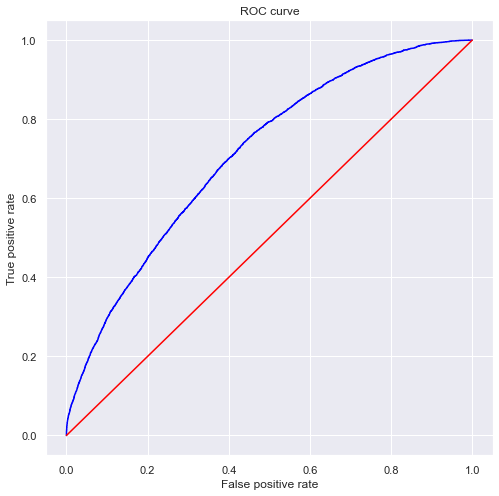

In [26]:
draw_roc_curve(fpr, tpr)

Причем catboost модель справилась в данном случае лучше.
И я даже не использовал categorial features.

In [27]:
def roc_auc_score(y_true, y_prob):
    fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)
    
    return auc(fpr, tpr)

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [29]:
params = {'max_depth': [1, 2, 3, 4, 5, 10, 15],
        'n_estimators': [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 300, 325, 350, 375, 400],
        'learning_rate': np.logspace(-2, 0, num=4)
         }

In [30]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [31]:
xgbc = XGBClassifier()

In [32]:
grid_xgbc = GridSearchCV(estimator=xgbc, 
                    param_grid=params, 
                    scoring='roc_auc', 
                    cv=skf.split(X_train[numerical], y_train), 
                    verbose=3)
grid_xgbc.fit(X_train[numerical], y_train)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits
[CV] learning_rate=0.01, max_depth=1, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1, score=0.630, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1, score=0.632, total=   0.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=1, score=0.626, total=   0.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2, score=0.630, total=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] learning_rate=0.01, max_depth=1, n_estimators=2 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2, score=0.635, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=2 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=2, score=0.626, total=   0.0s
[CV] learning_rate=0.01, max_depth=1, n_estimators=3 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=3, score=0.630, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=3 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=3, score=0.635, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=3 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=3, score=0.626, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=4 .................
[CV]  learning_rate=0.01, max_depth=1, n_estimators=4, score=0.630, total=   0.1s
[CV] learning_rate=0.01, max_depth=1, n_estimators=4 .................
[CV]  learn

[CV]  learning_rate=0.01, max_depth=1, n_estimators=400, score=0.688, total=   2.3s
[CV] learning_rate=0.01, max_depth=1, n_estimators=400 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=400, score=0.691, total=   2.2s
[CV] learning_rate=0.01, max_depth=1, n_estimators=400 ...............
[CV]  learning_rate=0.01, max_depth=1, n_estimators=400, score=0.681, total=   1.8s
[CV] learning_rate=0.01, max_depth=2, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=1, score=0.668, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=1, score=0.658, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=1 .................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=1, score=0.664, total=   0.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=2 .................
[CV]  learning_rate=0.01, max_depth=2, n_estimators=2, score=0.668, total=  

[CV]  learning_rate=0.01, max_depth=2, n_estimators=350, score=0.695, total=   2.1s
[CV] learning_rate=0.01, max_depth=2, n_estimators=350 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=350, score=0.695, total=   2.0s
[CV] learning_rate=0.01, max_depth=2, n_estimators=350 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=350, score=0.687, total=   1.9s
[CV] learning_rate=0.01, max_depth=2, n_estimators=375 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=375, score=0.696, total=   2.1s
[CV] learning_rate=0.01, max_depth=2, n_estimators=375 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=375, score=0.696, total=   2.2s
[CV] learning_rate=0.01, max_depth=2, n_estimators=375 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=375, score=0.687, total=   2.5s
[CV] learning_rate=0.01, max_depth=2, n_estimators=400 ...............
[CV]  learning_rate=0.01, max_depth=2, n_estimators=400, score=0.696, 

[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=0.696, total=   3.3s
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=0.697, total=   2.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=300, score=0.690, total=   2.1s
[CV] learning_rate=0.01, max_depth=3, n_estimators=325 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=325, score=0.697, total=   2.9s
[CV] learning_rate=0.01, max_depth=3, n_estimators=325 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=325, score=0.698, total=   2.7s
[CV] learning_rate=0.01, max_depth=3, n_estimators=325 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=325, score=0.690, total=   2.5s
[CV] learning_rate=0.01, max_depth=3, n_estimators=350 ...............
[CV]  learning_rate=0.01, max_depth=3, n_estimators=350, score=0.697, 

[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, score=0.697, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, score=0.698, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=200, score=0.690, total=   1.8s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, score=0.697, total=   2.2s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, score=0.699, total=   2.3s
[CV] learning_rate=0.01, max_depth=4, n_estimators=250 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=250, score=0.691, total=   2.2s
[CV] learning_rate=0.01, max_depth=4, n_estimators=300 ...............
[CV]  learning_rate=0.01, max_depth=4, n_estimators=300, score=0.697, 

[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.696, total=   1.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.698, total=   1.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=100 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=100, score=0.690, total=   1.1s
[CV] learning_rate=0.01, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, score=0.697, total=   1.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, score=0.699, total=   1.6s
[CV] learning_rate=0.01, max_depth=5, n_estimators=150 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=150, score=0.691, total=   1.5s
[CV] learning_rate=0.01, max_depth=5, n_estimators=200 ...............
[CV]  learning_rate=0.01, max_depth=5, n_estimators=200, score=0.697, 

[CV]  learning_rate=0.01, max_depth=10, n_estimators=25, score=0.686, total=   0.7s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, score=0.695, total=   1.4s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, score=0.699, total=   1.3s
[CV] learning_rate=0.01, max_depth=10, n_estimators=50 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=50, score=0.689, total=   1.2s
[CV] learning_rate=0.01, max_depth=10, n_estimators=75 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=75, score=0.696, total=   1.7s
[CV] learning_rate=0.01, max_depth=10, n_estimators=75 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=75, score=0.699, total=   1.8s
[CV] learning_rate=0.01, max_depth=10, n_estimators=75 ...............
[CV]  learning_rate=0.01, max_depth=10, n_estimators=75, score=0.690, 

[CV]  learning_rate=0.01, max_depth=15, n_estimators=15, score=0.685, total=   0.5s
[CV] learning_rate=0.01, max_depth=15, n_estimators=15 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=15, score=0.677, total=   0.5s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, score=0.686, total=   0.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, score=0.685, total=   0.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=20 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=20, score=0.678, total=   0.6s
[CV] learning_rate=0.01, max_depth=15, n_estimators=25 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=25, score=0.687, total=   0.8s
[CV] learning_rate=0.01, max_depth=15, n_estimators=25 ...............
[CV]  learning_rate=0.01, max_depth=15, n_estimators=25, score=0.686, 

[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=5, score=0.657, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=1, n_estimators=10 
[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=10, score=0.667, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=1, n_estimators=10 
[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=10, score=0.668, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=1, n_estimators=10 
[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=10, score=0.660, total=   0.2s
[CV] learning_rate=0.046415888336127774, max_depth=1, n_estimators=15 
[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=15, score=0.673, total=   0.2s
[CV] learning_rate=0.046415888336127774, max_depth=1, n_estimators=15 
[CV]  learning_rate=0.046415888336127774, max_depth=1, n_estimators=15, score=0.670, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=1

[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=2, score=0.668, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=2 .
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=2, score=0.677, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=2 .
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=2, score=0.664, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=3 .
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=3, score=0.668, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=3 .
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=3, score=0.678, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=3 .
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=3, score=0.665, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_e

[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=350, score=0.699, total=   2.3s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=350 
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=350, score=0.691, total=   2.3s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=375 
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=375, score=0.698, total=   2.6s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=375 
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=375, score=0.700, total=   2.3s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=375 
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=375, score=0.691, total=   2.1s
[CV] learning_rate=0.046415888336127774, max_depth=2, n_estimators=400 
[CV]  learning_rate=0.046415888336127774, max_depth=2, n_estimators=400, score=0.698, total=   2.4s
[CV] learning_rate=0.046415888336127774,

[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=200, score=0.692, total=   2.1s
[CV] learning_rate=0.046415888336127774, max_depth=3, n_estimators=250 
[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=250, score=0.699, total=   2.6s
[CV] learning_rate=0.046415888336127774, max_depth=3, n_estimators=250 
[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=250, score=0.701, total=   2.6s
[CV] learning_rate=0.046415888336127774, max_depth=3, n_estimators=250 
[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=250, score=0.692, total=   2.5s
[CV] learning_rate=0.046415888336127774, max_depth=3, n_estimators=300 
[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=300, score=0.699, total=   3.1s
[CV] learning_rate=0.046415888336127774, max_depth=3, n_estimators=300 
[CV]  learning_rate=0.046415888336127774, max_depth=3, n_estimators=300, score=0.701, total=   3.5s
[CV] learning_rate=0.046415888336127774,

[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=75, score=0.697, total=   1.0s
[CV] learning_rate=0.046415888336127774, max_depth=4, n_estimators=75 
[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=75, score=0.700, total=   1.0s
[CV] learning_rate=0.046415888336127774, max_depth=4, n_estimators=75 
[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=75, score=0.691, total=   1.2s
[CV] learning_rate=0.046415888336127774, max_depth=4, n_estimators=100 
[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=100, score=0.698, total=   1.4s
[CV] learning_rate=0.046415888336127774, max_depth=4, n_estimators=100 
[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=100, score=0.700, total=   1.6s
[CV] learning_rate=0.046415888336127774, max_depth=4, n_estimators=100 
[CV]  learning_rate=0.046415888336127774, max_depth=4, n_estimators=100, score=0.692, total=   1.5s
[CV] learning_rate=0.046415888336127774, max_

[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=15, score=0.695, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=5, n_estimators=15 
[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=15, score=0.698, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=5, n_estimators=15 
[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=15, score=0.690, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=5, n_estimators=20 
[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=20, score=0.696, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=5, n_estimators=20 
[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=20, score=0.699, total=   0.4s
[CV] learning_rate=0.046415888336127774, max_depth=5, n_estimators=20 
[CV]  learning_rate=0.046415888336127774, max_depth=5, n_estimators=20, score=0.690, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=

[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=3, score=0.692, total=   0.2s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=3 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=3, score=0.696, total=   0.2s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=3 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=3, score=0.685, total=   0.3s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=4 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=4, score=0.691, total=   0.2s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=4 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=4, score=0.698, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=4 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=4, score=0.685, total=   0.1s
[CV] learning_rate=0.046415888336127774, max_depth=

[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=375, score=0.696, total=   9.8s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=375 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=375, score=0.699, total=  10.5s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=375 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=375, score=0.690, total=  10.2s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=400 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=400, score=0.695, total=  10.7s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=400 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=400, score=0.698, total=  10.2s
[CV] learning_rate=0.046415888336127774, max_depth=10, n_estimators=400 
[CV]  learning_rate=0.046415888336127774, max_depth=10, n_estimators=400, score=0.689, total=  10.6s
[CV] learning_rate=0.04641588

[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=250, score=0.691, total=  10.1s
[CV] learning_rate=0.046415888336127774, max_depth=15, n_estimators=250 
[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=250, score=0.689, total=  10.4s
[CV] learning_rate=0.046415888336127774, max_depth=15, n_estimators=250 
[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=250, score=0.682, total=   8.1s
[CV] learning_rate=0.046415888336127774, max_depth=15, n_estimators=300 
[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=300, score=0.690, total=   9.2s
[CV] learning_rate=0.046415888336127774, max_depth=15, n_estimators=300 
[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=300, score=0.688, total=  13.0s
[CV] learning_rate=0.046415888336127774, max_depth=15, n_estimators=300 
[CV]  learning_rate=0.046415888336127774, max_depth=15, n_estimators=300, score=0.681, total=  12.4s
[CV] learning_rate=0.04641588

[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=75, score=0.696, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=1, n_estimators=75 .
[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=75, score=0.688, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=1, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=100, score=0.696, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=1, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=100, score=0.697, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=1, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=100, score=0.688, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=1, n_estimators=150 
[CV]  learning_rate=0.21544346900318834, max_depth=1, n_estimators=150, score=0.696, total=   0.8s
[CV] learning_rate=0.21544346900318834, max_depth=1, 

[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=20, score=0.696, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_estimators=20 .
[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=20, score=0.696, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_estimators=20 .
[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=20, score=0.688, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_estimators=25 .
[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=25, score=0.697, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_estimators=25 .
[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=25, score=0.698, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_estimators=25 .
[CV]  learning_rate=0.21544346900318834, max_depth=2, n_estimators=25, score=0.689, total=   0.3s
[CV] learning_rate=0.21544346900318834, max_depth=2, n_es

[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=5, score=0.693, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estimators=5 ..
[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=5, score=0.693, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estimators=5 ..
[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=5, score=0.686, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estimators=10 .
[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=10, score=0.695, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estimators=10 .
[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=10, score=0.695, total=   0.2s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estimators=10 .
[CV]  learning_rate=0.21544346900318834, max_depth=3, n_estimators=10, score=0.688, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=3, n_estim

[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=2, score=0.693, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=2 ..
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=2, score=0.695, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=2 ..
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=2, score=0.688, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=3 ..
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=3, score=0.694, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=3 ..
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=3, score=0.696, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=3 ..
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=3, score=0.690, total=   0.1s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimato

[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=350, score=0.702, total=   3.4s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=350 
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=350, score=0.693, total=   3.2s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=375 
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=375, score=0.697, total=   3.4s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=375 
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=375, score=0.702, total=   3.3s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=375 
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=375, score=0.693, total=   3.3s
[CV] learning_rate=0.21544346900318834, max_depth=4, n_estimators=400 
[CV]  learning_rate=0.21544346900318834, max_depth=4, n_estimators=400, score=0.696, total=   3.4s
[CV] learning_rate=0.21544346900318834, max_depth=4

[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=200, score=0.693, total=   2.2s
[CV] learning_rate=0.21544346900318834, max_depth=5, n_estimators=250 
[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=250, score=0.694, total=   2.5s
[CV] learning_rate=0.21544346900318834, max_depth=5, n_estimators=250 
[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=250, score=0.700, total=   2.5s
[CV] learning_rate=0.21544346900318834, max_depth=5, n_estimators=250 
[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=250, score=0.692, total=   2.5s
[CV] learning_rate=0.21544346900318834, max_depth=5, n_estimators=300 
[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=300, score=0.694, total=   3.1s
[CV] learning_rate=0.21544346900318834, max_depth=5, n_estimators=300 
[CV]  learning_rate=0.21544346900318834, max_depth=5, n_estimators=300, score=0.697, total=   2.9s
[CV] learning_rate=0.21544346900318834, max_depth=5

[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=75, score=0.694, total=   1.7s
[CV] learning_rate=0.21544346900318834, max_depth=10, n_estimators=75 
[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=75, score=0.696, total=   1.7s
[CV] learning_rate=0.21544346900318834, max_depth=10, n_estimators=75 
[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=75, score=0.689, total=   1.4s
[CV] learning_rate=0.21544346900318834, max_depth=10, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=100, score=0.692, total=   2.2s
[CV] learning_rate=0.21544346900318834, max_depth=10, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=100, score=0.694, total=   3.2s
[CV] learning_rate=0.21544346900318834, max_depth=10, n_estimators=100 
[CV]  learning_rate=0.21544346900318834, max_depth=10, n_estimators=100, score=0.686, total=   2.1s
[CV] learning_rate=0.21544346900318834, max_d

[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=15, score=0.688, total=   0.5s
[CV] learning_rate=0.21544346900318834, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=15, score=0.690, total=   0.7s
[CV] learning_rate=0.21544346900318834, max_depth=15, n_estimators=15 
[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=15, score=0.682, total=   0.6s
[CV] learning_rate=0.21544346900318834, max_depth=15, n_estimators=20 
[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=20, score=0.688, total=   0.7s
[CV] learning_rate=0.21544346900318834, max_depth=15, n_estimators=20 
[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=20, score=0.691, total=   0.8s
[CV] learning_rate=0.21544346900318834, max_depth=15, n_estimators=20 
[CV]  learning_rate=0.21544346900318834, max_depth=15, n_estimators=20, score=0.682, total=   0.9s
[CV] learning_rate=0.21544346900318834, max_depth=1

[CV]  learning_rate=1.0, max_depth=1, n_estimators=3, score=0.673, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=3 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=3, score=0.664, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=4 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=4, score=0.678, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=4 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=4, score=0.678, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=4 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=4, score=0.673, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=5 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=5, score=0.666, total=   0.1s
[CV] learning_rate=1.0, max_depth=1, n_estimators=5 ..................
[CV]  learning_rate=1.0, max_depth=1, n_estimators=5, score=0.672, total=   0.1s
[CV] le

[CV] learning_rate=1.0, max_depth=2, n_estimators=2 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=2, score=0.678, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=2 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=2, score=0.676, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=3 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=3, score=0.688, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=3 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=3, score=0.682, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=3 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=3, score=0.681, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=4 ..................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=4, score=0.692, total=   0.1s
[CV] learning_rate=1.0, max_depth=2, n_estimators=4 ..................
[CV]  learning_ra

[CV]  learning_rate=1.0, max_depth=2, n_estimators=400, score=0.687, total=   2.5s
[CV] learning_rate=1.0, max_depth=2, n_estimators=400 ................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=400, score=0.692, total=   2.2s
[CV] learning_rate=1.0, max_depth=2, n_estimators=400 ................
[CV]  learning_rate=1.0, max_depth=2, n_estimators=400, score=0.682, total=   2.6s
[CV] learning_rate=1.0, max_depth=3, n_estimators=1 ..................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=1, score=0.686, total=   0.0s
[CV] learning_rate=1.0, max_depth=3, n_estimators=1 ..................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=1, score=0.683, total=   0.1s
[CV] learning_rate=1.0, max_depth=3, n_estimators=1 ..................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=1, score=0.679, total=   0.1s
[CV] learning_rate=1.0, max_depth=3, n_estimators=2 ..................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=2, score=0.691, total=   0.1s
[

[CV]  learning_rate=1.0, max_depth=3, n_estimators=350, score=0.678, total=   2.4s
[CV] learning_rate=1.0, max_depth=3, n_estimators=350 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=350, score=0.685, total=   2.5s
[CV] learning_rate=1.0, max_depth=3, n_estimators=350 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=350, score=0.670, total=   2.5s
[CV] learning_rate=1.0, max_depth=3, n_estimators=375 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=375, score=0.678, total=   2.7s
[CV] learning_rate=1.0, max_depth=3, n_estimators=375 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=375, score=0.685, total=   2.6s
[CV] learning_rate=1.0, max_depth=3, n_estimators=375 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=375, score=0.670, total=   2.7s
[CV] learning_rate=1.0, max_depth=3, n_estimators=400 ................
[CV]  learning_rate=1.0, max_depth=3, n_estimators=400, score=0.677, total= 

[CV]  learning_rate=1.0, max_depth=4, n_estimators=300, score=0.673, total=   2.6s
[CV] learning_rate=1.0, max_depth=4, n_estimators=300 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=300, score=0.672, total=   2.5s
[CV] learning_rate=1.0, max_depth=4, n_estimators=300 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=300, score=0.664, total=   2.5s
[CV] learning_rate=1.0, max_depth=4, n_estimators=325 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=325, score=0.670, total=   2.7s
[CV] learning_rate=1.0, max_depth=4, n_estimators=325 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=325, score=0.671, total=   2.7s
[CV] learning_rate=1.0, max_depth=4, n_estimators=325 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=325, score=0.662, total=   2.7s
[CV] learning_rate=1.0, max_depth=4, n_estimators=350 ................
[CV]  learning_rate=1.0, max_depth=4, n_estimators=350, score=0.668, total= 

[CV]  learning_rate=1.0, max_depth=5, n_estimators=200, score=0.671, total=   2.0s
[CV] learning_rate=1.0, max_depth=5, n_estimators=200 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=200, score=0.668, total=   2.3s
[CV] learning_rate=1.0, max_depth=5, n_estimators=200 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=200, score=0.659, total=   2.1s
[CV] learning_rate=1.0, max_depth=5, n_estimators=250 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=250, score=0.668, total=   2.7s
[CV] learning_rate=1.0, max_depth=5, n_estimators=250 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=250, score=0.667, total=   2.6s
[CV] learning_rate=1.0, max_depth=5, n_estimators=250 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=250, score=0.658, total=   2.6s
[CV] learning_rate=1.0, max_depth=5, n_estimators=300 ................
[CV]  learning_rate=1.0, max_depth=5, n_estimators=300, score=0.667, total= 

[CV]  learning_rate=1.0, max_depth=10, n_estimators=100, score=0.661, total=   2.0s
[CV] learning_rate=1.0, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=100, score=0.658, total=   1.9s
[CV] learning_rate=1.0, max_depth=10, n_estimators=100 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=100, score=0.652, total=   1.9s
[CV] learning_rate=1.0, max_depth=10, n_estimators=150 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=150, score=0.657, total=   2.9s
[CV] learning_rate=1.0, max_depth=10, n_estimators=150 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=150, score=0.656, total=   2.8s
[CV] learning_rate=1.0, max_depth=10, n_estimators=150 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=150, score=0.649, total=   3.8s
[CV] learning_rate=1.0, max_depth=10, n_estimators=200 ...............
[CV]  learning_rate=1.0, max_depth=10, n_estimators=200, score=0.656, 

[CV]  learning_rate=1.0, max_depth=15, n_estimators=50, score=0.656, total=   1.5s
[CV] learning_rate=1.0, max_depth=15, n_estimators=50 ................
[CV]  learning_rate=1.0, max_depth=15, n_estimators=50, score=0.652, total=   1.5s
[CV] learning_rate=1.0, max_depth=15, n_estimators=50 ................
[CV]  learning_rate=1.0, max_depth=15, n_estimators=50, score=0.654, total=   1.5s
[CV] learning_rate=1.0, max_depth=15, n_estimators=75 ................
[CV]  learning_rate=1.0, max_depth=15, n_estimators=75, score=0.655, total=   2.2s
[CV] learning_rate=1.0, max_depth=15, n_estimators=75 ................
[CV]  learning_rate=1.0, max_depth=15, n_estimators=75, score=0.653, total=   2.2s
[CV] learning_rate=1.0, max_depth=15, n_estimators=75 ................
[CV]  learning_rate=1.0, max_depth=15, n_estimators=75, score=0.650, total=   2.2s
[CV] learning_rate=1.0, max_depth=15, n_estimators=100 ...............
[CV]  learning_rate=1.0, max_depth=15, n_estimators=100, score=0.651, total=

[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed: 53.7min finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x132a4e408>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
           

1 hour later..

In [34]:
grid_xgbc.best_params_

{'learning_rate': 0.046415888336127774, 'max_depth': 5, 'n_estimators': 350}

In [35]:
grid_xgbc.best_score_

0.7004529757072943

In [36]:
preds_proba = grid_xgbc.predict_proba(X_test[numerical])
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [37]:
roc_auc_score(y_test, preds_proba[:, 1])

0.7107844070631494

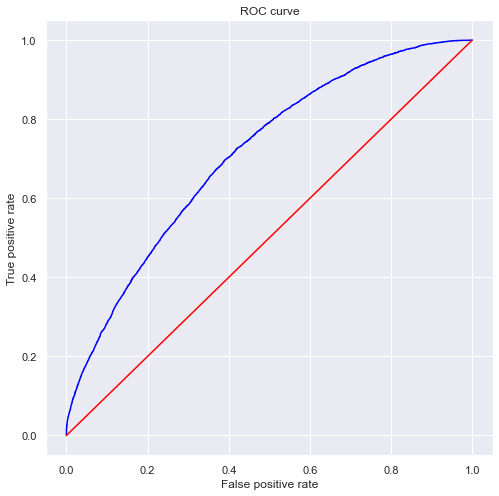

In [38]:
draw_roc_curve(fpr, tpr)

Собственно, результат похож на результат "из коробки". Baseline также побивает.

In [39]:
cb = CatBoostClassifier()

In [ ]:
grid_cb = GridSearchCV(estimator=cb, 
                    param_grid=params, 
                    scoring='roc_auc', 
                    cv=skf.split(X_train[numerical], y_train), 
                    verbose=3)
grid_cb.fit(X_train[numerical], y_train)

2 hours later.. (probably more)
<br>CatBoost ооочень долгий, я не дождался. Baseline все равно побили.

In [ ]:
grid_cb.best_params_

In [ ]:
grid_cb.best_score_

In [ ]:
preds_proba = grid_cb.predict_proba(X_test[numerical])
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [ ]:
roc_auc_score(y_test, preds_proba[:, 1])

In [ ]:
draw_roc_curve(fpr, tpr)

Давайте теперь еще подключим categorical features:

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
xgbc = XGBClassifier(n_estimators=350,
                    depth=5,
                    learning_rate=0.046415888336127774,
                    verbose=False)
xgbc.fit(X_train_ohe, y_train)

[22:01:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { depth, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, depth=5, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.046415888336127774, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=350, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbose=False,
              verbosity=None)

In [45]:
preds_proba = xgbc.predict_proba(X_test_ohe)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [46]:
roc_auc_score(y_test, preds_proba[:, 1])

0.7452621448056067

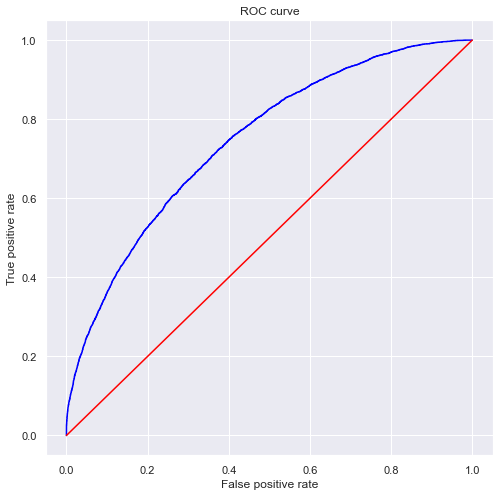

In [47]:
draw_roc_curve(fpr, tpr)

Видим, что при добавление категориальных признаков качество значимо возрастает.

In [48]:
cbc = CatBoostClassifier(n_estimators=350,
                        depth=5,
                        learning_rate=0.046415888336127774,
                        verbose=False)
cbc.fit(X_train_ohe, y_train)

In [52]:
preds_proba = cbc.predict_proba(X_test_ohe)
fpr, tpr, thresholds = metrics.roc_curve(y_test, preds_proba[:, 1])

In [53]:
roc_auc_score(y_test, preds_proba[:, 1])

0.7354102645989476

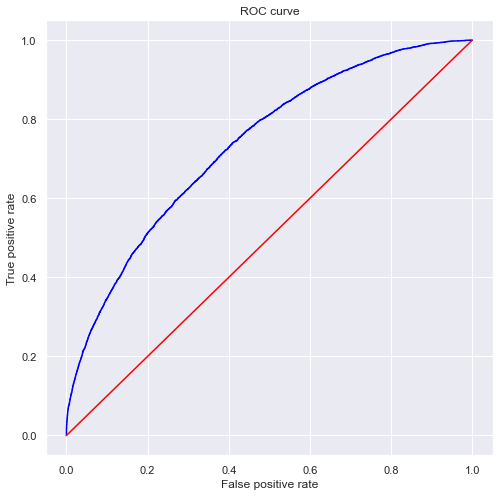

In [54]:
draw_roc_curve(fpr, tpr)

Качество также значимо возрасло, но у XGBoost результат лучше.